## Simulate White/Pink/Brown Noise MFDFA

White noise = $\frac{1}{f^{0}}$ 

Pink noise = $\frac{1}{f^{1}}$ 

Brownian noise = $\frac{1}{f^{2}}$

### Get 20 samples of each noise

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import colorednoise as cn

In [2]:
colors = []
sigs = []

## for every color
for beta, color in zip([0, 1, 2], ['white', 'pink', 'brown']):
    ## generate 100
    for n in np.arange(0, 100):
        samples = 12000 # number of samples to generate
        sigs.append(cn.powerlaw_psd_gaussian(beta, samples))
        colors.append(color)

In [3]:
noises = pd.DataFrame(
    {
        'colors' : colors,
        'sigs' : sigs
    }
)

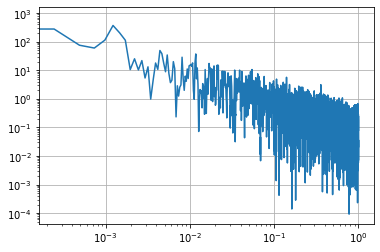

In [4]:
# optionally plot the Power Spectral Density with Matplotlib
from matplotlib import mlab
from matplotlib import pylab as plt

y = noises[noises['colors'] == 'pink'].sigs.values[0]

s, f = mlab.psd(y, NFFT=2**13)
plt.loglog(f,s)
plt.grid(True)
plt.show()

## Apply MFDFA on noise simulations

In [5]:
import numpy as np
from starling_rhythm.mfdfa import hurst_expo
from joblib import Parallel, delayed
from tqdm.autonotebook import tqdm

/home/AD/j8xing/anaconda3/envs/starling_rhythm/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
n_jobs = 36 ## set up joblib parameters
verbose = 0

In [7]:
with Parallel(n_jobs = n_jobs, verbose = verbose) as parallel:
    h_expos = parallel(
        delayed(hurst_expo)(
            amp_env
        ) 
        for amp_env in tqdm(noises.sigs.values, desc = "Retrieving Hurst Exponents for All Noises.")
    )

Retrieving Hurst Exponents for All Noises.: 100%|██████████| 300/300 [00:12<00:00, 24.99it/s]


In [8]:
## Get MF_range
MF_range = []
for h_expo in h_expos:
    MF_range.append(max(h_expo) - min(h_expo))

In [9]:
noises['h_expo'] = h_expos
noises['MF_range'] = MF_range

In [10]:
noises.head()

,colors,sigs,h_expo,MF_range
0,white,"[1.2563109820240386, -0.45513633461794484, -0....","[0.5229276328983337, 0.5165656324242086, 0.511...",0.038227
1,white,"[-0.8667237813669073, -0.6235838654709615, -1....","[0.5274781384866164, 0.5222952012651371, 0.518...",0.029477
2,white,"[0.012419915106670521, 0.31661664221708563, -1...","[0.498109544731015, 0.49269058297039786, 0.488...",0.031286
3,white,"[-1.2737527735232312, 0.2301597716142453, -0.4...","[0.5395775606918147, 0.5328196549427745, 0.527...",0.041617
4,white,"[0.5910650743477173, 0.29941144953251503, -1.4...","[0.5207566026513046, 0.5140043071790541, 0.508...",0.041999


## Produce IAAFT surrogates

In [11]:
import starling_rhythm.iaaft as iaaft
from starling_rhythm.mfdfa import hurst_expo
from joblib import Parallel, delayed
from timeit import timeit
from tqdm.autonotebook import tqdm

In [12]:
def SDoMF_iaaft(amp_env, ns = 32):
    '''
    For each amplitude envelope, find some number of its surrogates, and find MF_range for all surrogates
    '''
    
    ## calculate its surrogates
    surrogates = iaaft.surrogates(amp_env, ns = ns, maxiter = 10000, verbose = True)
    
    ## container for SDoMF_iaaft
    SDoMF = []
    
    ## find all the Hurst exponents of all the surrogates
    for surrogate in surrogates:
        ## Output Hs for each surrogate
        h_expos = hurst_expo(surrogate)
        SDoMF.append(max(h_expos) - min(h_expos))
            
    return SDoMF

In [13]:
with Parallel(n_jobs = n_jobs, verbose = verbose) as parallel:
    mf_ranges = parallel(
        delayed(SDoMF_iaaft)(
            amp_env
        )
        for amp_env in tqdm(noises.sigs.values, desc = 'Running Surrogate Data')
    )

Running Surrogate Data: 100%|██████████| 300/300 [09:50<00:00,  1.97s/it]


In [14]:
noises['mf_iaaft_range'] = mf_ranges

## Parse t-statistics

In [15]:
import scipy.stats as stats
import numpy as np

In [16]:
ts = []
p = []
for MF_range, mf_iaaft_range in zip(noises['MF_range'].values, noises['mf_iaaft_range']):
    test = stats.ttest_1samp(mf_iaaft_range, MF_range)
    ts.append(test[0])
    p.append(test[1])
    
noises['ts'] = ts
noises['p'] = p

In [17]:
import statsmodels.stats.multitest

In [18]:
bonferroni = statsmodels.stats.multitest.multipletests(noises['p'].values, alpha = 0.05, method = 'bonferroni')
noises['sig'] = bonferroni[0]
noises['bonf_p'] = bonferroni[1]

In [19]:
noises.head()

,colors,sigs,h_expo,MF_range,mf_iaaft_range,ts,p,sig,bonf_p
0,white,"[1.2563109820240386, -0.45513633461794484, -0....","[0.5229276328983337, 0.5165656324242086, 0.511...",0.038227,"[0.03286102782783307, 0.042146759276472434, 0....",-3.419081,1.778687e-03,False,0.533606
1,white,"[-0.8667237813669073, -0.6235838654709615, -1....","[0.5274781384866164, 0.5222952012651371, 0.518...",0.029477,"[0.03429118395007058, 0.030372963668928887, 0....",6.677581,1.813572e-07,True,0.000054
2,white,"[0.012419915106670521, 0.31661664221708563, -1...","[0.498109544731015, 0.49269058297039786, 0.488...",0.031286,"[0.04141161343402566, 0.03386152159875194, 0.0...",7.529801,1.739026e-08,True,0.000005
3,white,"[-1.2737527735232312, 0.2301597716142453, -0.4...","[0.5395775606918147, 0.5328196549427745, 0.527...",0.041617,"[0.037979386208426225, 0.03490026081221431, 0....",-6.077013,9.857923e-07,True,0.000296
4,white,"[0.5910650743477173, 0.29941144953251503, -1.4...","[0.5207566026513046, 0.5140043071790541, 0.508...",0.041999,"[0.04032164534455379, 0.041731073588470724, 0....",-6.696956,1.718028e-07,True,0.000052


In [28]:
### Out of all white noises, how many are significantly multifractal?
np.unique(noises[noises['colors'] == 'white']['sig'].values, return_counts = True) 

(array([False,  True]), array([59, 41]))

In [32]:
### Out of all white noises that are negative, how many are significantly multifractal?
np.unique(noises[(noises['colors'] == 'white') & (noises['ts'] < 0 )]['sig'].values, return_counts = True)

(array([False,  True]), array([34, 20]))

<AxesSubplot:xlabel='ts', ylabel='Density'>

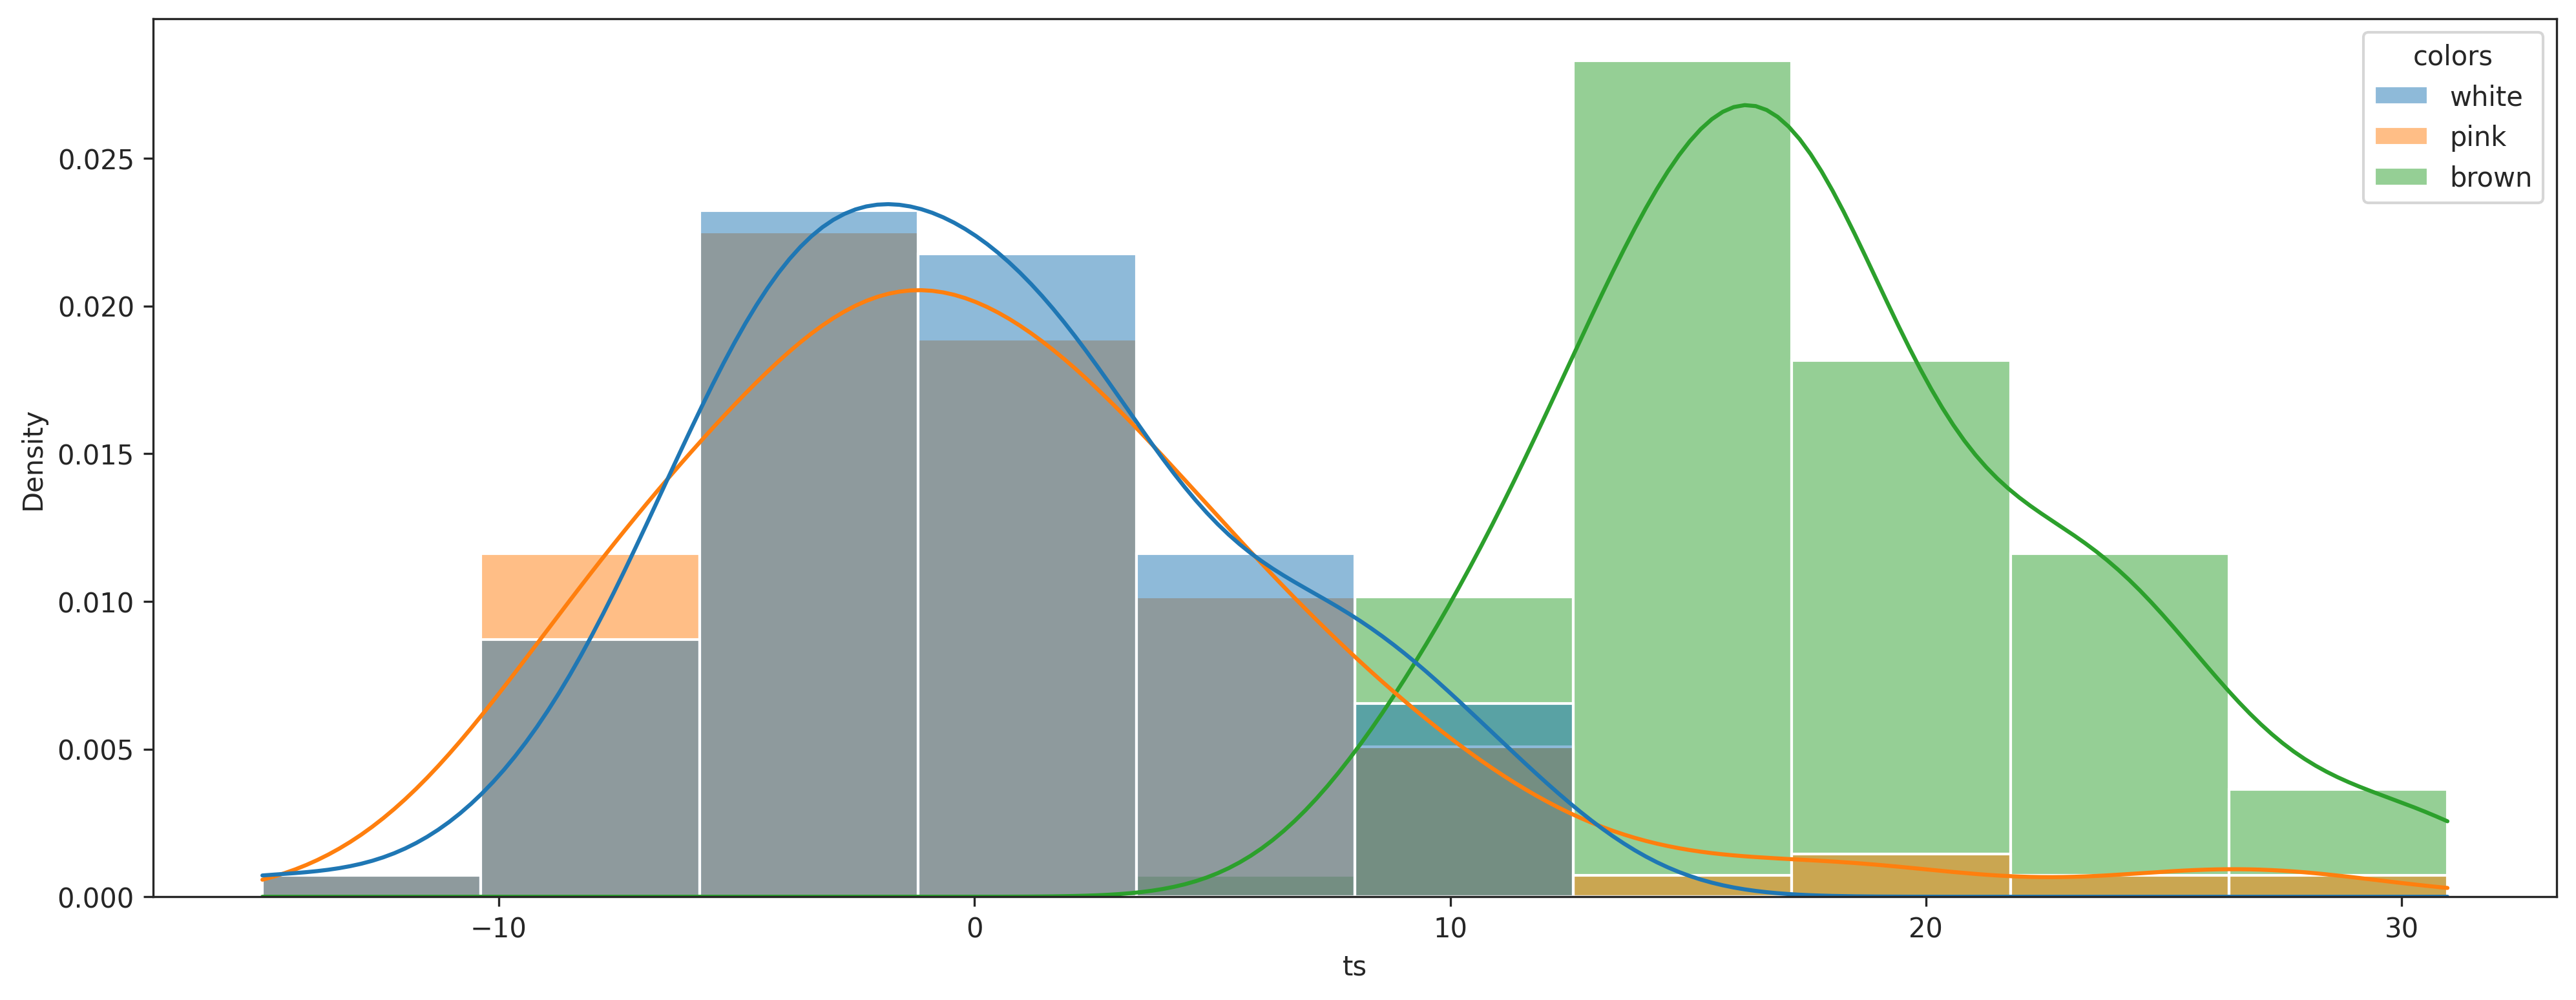

In [21]:
### distribution?
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

plt.rcParams['patch.edgecolor'] = 'none'
figure(figsize = (16, 6), dpi = 300)
sns.set_style('ticks')

sns.histplot(data = noises, x = 'ts', stat = 'density', color = 'black', hue = 'colors', kde = True) ## sampling rate of white noise